## Notebook Overview: Timeline Creation and Final Analysis

This notebook provides the final analysis portion of the project, including the steps used in creating the timelines for each individual user after intial data of infection. The steps covered in this notebook are
- Analysis of original cleaned dataset
- Analysis of users self-reporting symptoms of interest
- Analysis of users self-reporting positive date of infection
- Creating a timeline between infection date and symptoms of interest
- Analysis of final subset of users reporting both positive infection and symptoms of interest

In [334]:
import pandas as pd
from glob import glob
import os
import pandas as pd
import sqlite3
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from datetime import datetime

In [89]:
# set matplotlib default plotting style
plt.style.use("ggplot")

## Inital Data Set

The initial data set consists of the ouputs from the raw Facebook post cleaning process ([cleaning notebook](fb_post_cleaning.ipynb)). All data was obtained from the web-scraping process ([scraping notebook](fb_scraper.ipynb)) The code below does some basic aggregation and counts for posts, comments, and replies.


In [5]:
# Load the original data set before trimming
datadir = r"C:\Users\keatu\Regis_archive\practicum_data"
dbfile = os.path.join(datadir,"Facebook.db")
con = sqlite3.connect(dbfile)
posts = pd.read_sql("select * from posts",con)
comments = pd.read_sql("select * from comments", con)
replies = pd.read_sql("Select * from replies",con)
con.close()

In [301]:
# Combine all data types into one data frame for aggregation
posts['type'] = "posts"
comments['type'] = "comments"
replies['type'] = "replies"
all_points = pd.concat([
                    posts[["user_id","post_id","type","time"]],
                    comments[["commenter_id","comment_id","type","comment_time"]].rename(columns={"commenter_id":"user_id","comment_id":"post_id","comment_time":"time"}),
                    replies[["commenter_id","comment_id","type","comment_time"]].rename(columns={"commenter_id":"user_id","comment_id":"post_id","comment_time":"time"})
                    ], sort = False)

In [426]:
# look at total size of the cleaned data
len(all_points)

36972

In [417]:
# count number of unique users and posts by type
all_points.groupby("type").aggregate({"user_id":"nunique","post_id":"count"}).reset_index().rename(columns={"type":"Post Type","user_id":"Unique Users","post_id":"# of Posts"}).sort_values("# of Posts")

Post Type  Unique Users  # of Posts
1     posts           149         528
0  comments           997       10782
2   replies           954       25662

In [49]:
# look at metrics for posts per user
posts_per_user = all_points.groupby("user_id").aggregate({"post_id":"count"}).reset_index()
num_posts = posts_per_user["post_id"]
print("### Posts Per User ###")
num_posts.describe(percentiles = [.05,.95])

### Posts Per User ###


count    22585.000000
mean         8.423290
std         21.782057
min          1.000000
5%           1.000000
50%          3.000000
95%         32.000000
max        878.000000
Name: post_id, dtype: float64

In [304]:
# create datetime object column from timstamp
all_points["date_time"] = pd.to_datetime(all_points['time'])

In [316]:
# aggregate and count number of posts per month
month_counts = all_points.groupby([all_points["date_time"].dt.year, all_points["date_time"].dt.month]).aggregate({"user_id":"count"})
month_counts.index = month_counts.index.set_names(["year","month"])
month_counts = month_counts.reset_index()
month_counts["year_month"] = pd.to_datetime((month_counts["month"].astype(str)+"-"+month_counts["year"].astype(str)), format = r'%m-%Y')

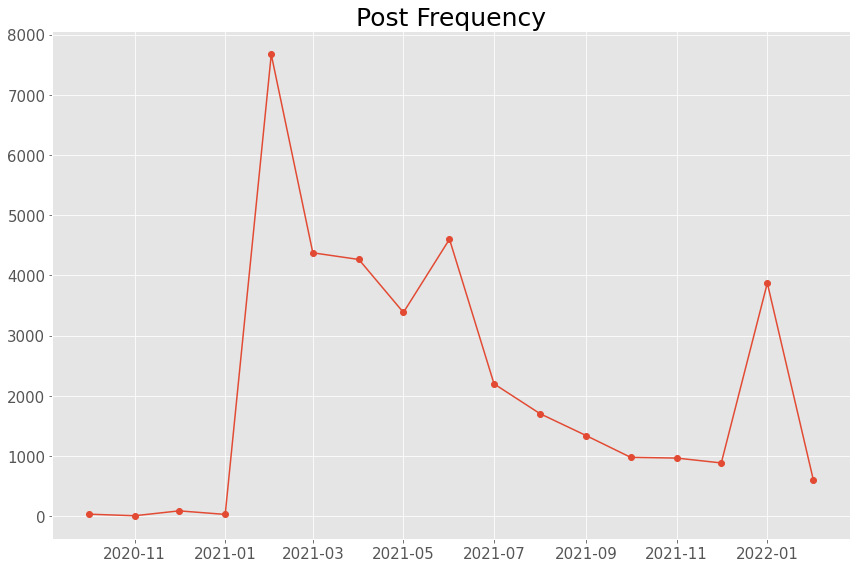

In [319]:
# plot post frequency over time aggregating per month
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(month_counts["year_month"],month_counts["user_id"].astype(int), '-o')
ax.tick_params(axis='y', labelsize = 15)
ax.tick_params(axis='x', labelsize = 15)
ax.set_title("Post Frequency", size = 25)
plt.tight_layout()
plt.show()

## Trim Down to Self-reporting Symptoms

After creating the initial datasets for the posts, comments, and replies, the next big steps involved creating a method for parsing the text strings to find users self-reporting symptoms. Rather than searching for all possible symptoms, the dataset was cut down to look at only users reporting symptoms specified by the School of Pharmacy--pathologies linked to cardiovascular issues after covid. Code for this data set is here: [self-reporting symptoms notebook](nlp_sentence_transformer_self_report.ipynb).

In [421]:
# Load the self-reporting symptoms data set
datadir = r"C:\Users\keatu\Regis_archive\practicum_data"
dbfile = os.path.join(datadir,"Facebook_Self_Report.db")
con = sqlite3.connect(dbfile)
self_reporting = pd.read_sql("select * from symptom_reporting",con)
con.close()

In [422]:
# replacing pulmonary embolism with the abbrevation pe
self_reporting["symptom"] = self_reporting["symptom"].replace("pulmonary embolism","pe")

In [147]:
# show data set size before and after removing duplicates
print("Total size of dataset: {}".format(len(self_reporting)))
# remove duplicate users with same symptoms
tr_self_reporting = self_reporting.sort_values("cos_similarity", ascending=False).groupby(["user_id","symptom"]).aggregate("first").reset_index()
print("Total after removing duplicates: {}".format(len(tr_self_reporting)))

Total size of dataset: 1340
Total after removing duplicates: 1119


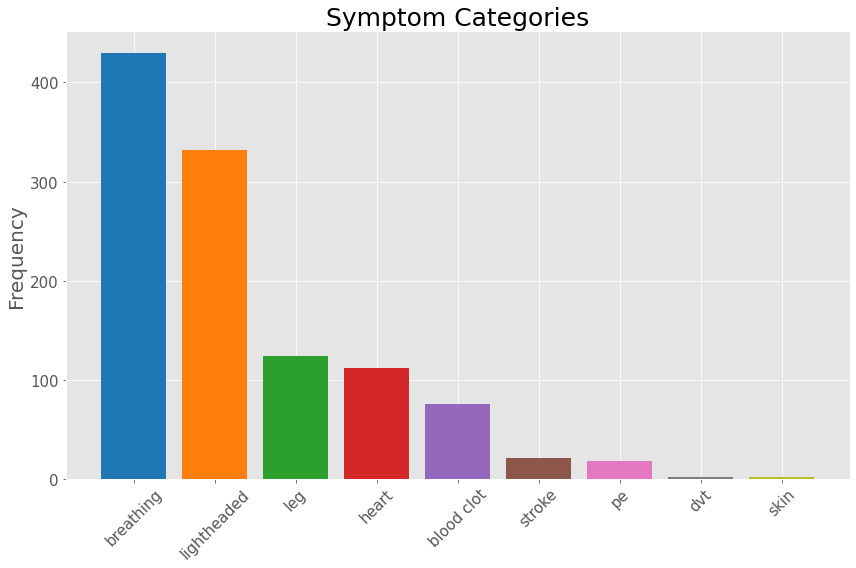

In [255]:
# plot total counts for each symptom category
fig, ax = plt.subplots(figsize = (12,8))
symptom_counts = tr_self_reporting["symptom"].value_counts()
ax.bar(symptom_counts.index,symptom_counts.values, color = list(mcolors.TABLEAU_COLORS.values()))
ax.set_xticklabels(symptom_counts.index,rotation=45, size = 15)
ax.tick_params(axis='y', labelsize = 15)
ax.set_title("Symptom Categories", size = 25)
ax.set_ylabel("Frequency", size = 20)
plt.tight_layout()
plt.show()


In [195]:
# Count number of users reporting 1 or more symptoms
symptoms_per_user = tr_self_reporting.groupby("user_id").aggregate({"symptom":"count"}).reset_index()
symptoms_per_user.groupby("symptom").aggregate({"user_id":"count"}).reset_index().rename(columns={"symptom": "Symptom Count","user_id":"Total Users"})
#print(pd.DataFrame(symptoms_per_user["symptom"].value_counts(), ["# of Posts", "total users"]))

Symptom Count  Total Users
0              1          973
1              2           63
2              3            4
3              4            2

In [413]:
# Find highest co-incident symptoms for users reporting multiple symptoms
unique_symptoms = tr_self_reporting.groupby("user_id").aggregate({"symptom":"unique"})
unique_symptoms["symptom"] = unique_symptoms["symptom"].apply(sorted)
unique_symptoms[unique_symptoms["symptom"].map(len)>1]["symptom"].value_counts()

[breathing, lightheaded]                     17
[breathing, heart]                           13
[breathing, leg]                              8
[blood clot, leg]                             5
[blood clot, breathing]                       4
[heart, lightheaded]                          4
[blood clot, lightheaded]                     2
[blood clot, pe]                              2
[lightheaded, stroke]                         1
[blood clot, heart, leg]                      1
[lightheaded, pe]                             1
[breathing, heart, leg]                       1
[breathing, pe]                               1
[breathing, heart, lightheaded]               1
[breathing, heart, lightheaded, pe]           1
[leg, lightheaded]                            1
[breathing, dvt]                              1
[blood clot, dvt]                             1
[breathing, stroke]                           1
[blood clot, breathing, leg, lightheaded]     1
[breathing, leg, lightheaded]           

In [202]:
# convert cosine similarity to a float for plotting
tr_self_reporting["cos_similarity"] = tr_self_reporting["cos_similarity"].astype(float)

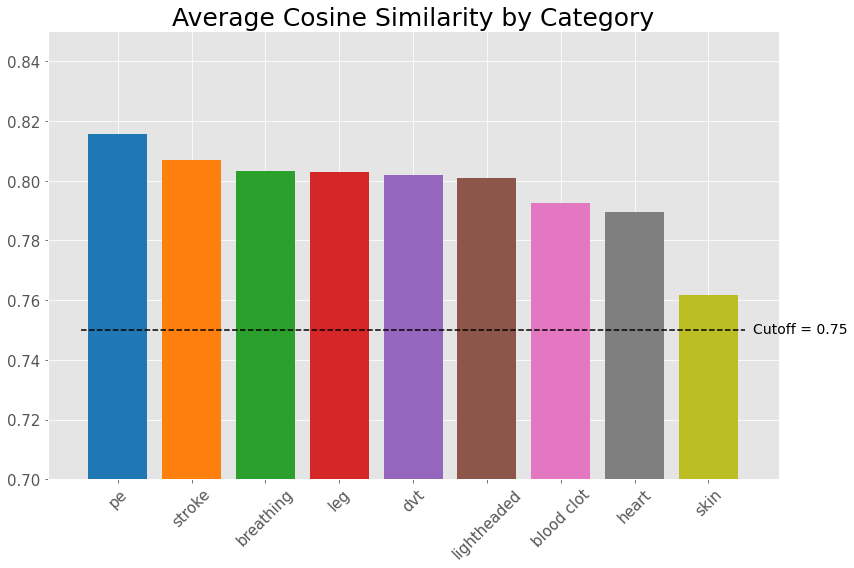

In [284]:
# Highest confidence based on cosine similarity score
fig, ax = plt.subplots(figsize = (12,8))
symptom_scores = tr_self_reporting.groupby("symptom").aggregate({"cos_similarity":"mean"}).sort_values("cos_similarity", ascending=False).reset_index()
ax.bar(symptom_scores["symptom"],symptom_scores["cos_similarity"], color = list(mcolors.TABLEAU_COLORS.values()))
ax.hlines(y = [0.75], xmin = -0.5, xmax = 8.5, color="k", linestyle="--")
ax.text(8.6,0.749, "Cutoff = 0.75", size = 14, color="k")
ax.set_xticklabels(symptom_scores["symptom"],rotation=45, size = 15)
ax.tick_params(axis='y', labelsize = 15)
ax.set_title("Average Cosine Similarity by Category", size = 25)
ax.set_ylim(0.7,0.85)
plt.tight_layout()
plt.show()

## Trim down to self-reporting positive diagnosis

Next, we examine only those users reporting a positive dianosis of Covid and, more specifically, reporting a time of diagnosis. To save processing time, this analysis was only performed on the posts from users self-reporting symptoms of interest. Code for this dataset is here: [self-reporting positive notebook](nlp_sentence_transformer_positive.ipynb)

In [256]:
# Load the self-reporting positive diagnosis data set
datadir = r"C:\Users\keatu\Regis_archive\practicum_data"
dbfile = os.path.join(datadir,"Facebook_Self_Report.db")
con = sqlite3.connect(dbfile)
positive_reporting = pd.read_sql("select * from positive_reporting",con)
con.close()

In [257]:
# Look at size of dataset
print("Total size of data set: {}".format(len(positive_reporting)))
print("Number of unique users: {}".format(positive_reporting.user_id.nunique()))

Total size of data set: 230
Number of unique users: 228


In [258]:
# look at a sample of the data
positive_reporting.head()

index      cos_similarity                    match_sentence  \
0      0  0.8587771059999999              diagnosed with covid   
1      9         0.761919975     it has been since I had covid   
2     10          0.81340313                    I had covid-19   
3     12  0.7756297590000001  it has been since I had covid-19   
4     13         0.816642284                 I tested positive   

             post_id                                           sentence  \
0  459081000000000.0                 Diagnosed with covid December 1st.   
1  449846000000000.0    It was almost 11 months ago I contracted Covid.   
2  621771000000000.0                  I had Covid in December 9th 2020.   
3  467850000000000.0  I had covid symptoms in Feb 2020 before it was...   
4  508219000000000.0                     I tested positive in November.   

           user_id            time date_reported  
0  100000019242394   3/3/2021 4:35       12/2021  
1  100000079697297  2/7/2021 23:34        3/2020  
2  100000107921091  12/3/2021 4:36       12/2020  
3  100000143694179  3/5/2021 23:43        2/2020  
4  100000145906039   6/8/2021 9:54       11/2021

In [262]:
# convert date_reported field to a datetime object
positive_reporting["date_reported"] = pd.to_datetime(positive_reporting['date_reported'], format = r'%m/%Y')

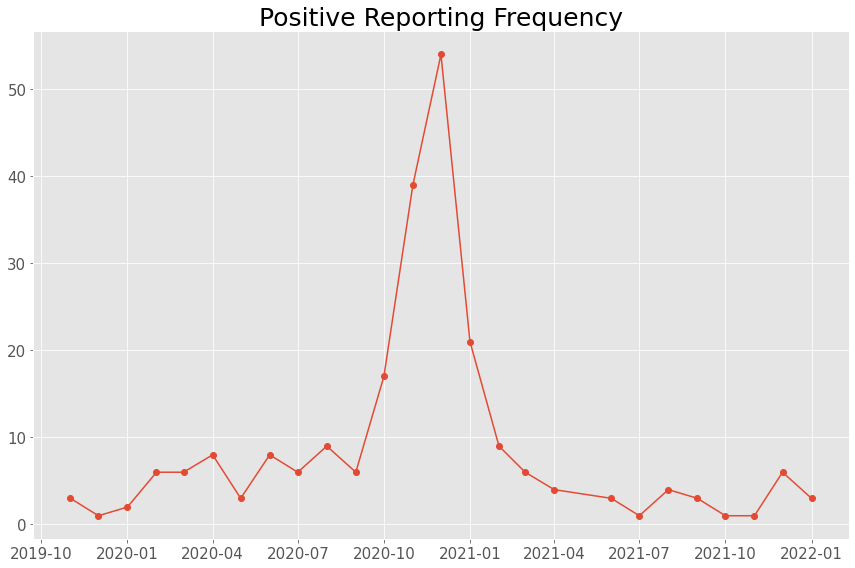

In [427]:
# Examine timestamps of self-reporting positive users
fig, ax = plt.subplots(figsize = (12,8))
month_frequency = positive_reporting.groupby("date_reported").aggregate({"user_id":"count"}).reset_index()
ax.plot(month_frequency["date_reported"],month_frequency["user_id"].astype(int), '-o')
ax.tick_params(axis='y', labelsize = 15)
ax.tick_params(axis='x', labelsize = 15)
ax.set_title("Positive Reporting Frequency", size = 25)
#ax.set_ylim(0.7,0.85)
plt.tight_layout()
plt.show()


## Examine Final Dataset

In this last set, we examine the intersection between users reporting a positive date of infection and users reporting symptoms of interest. With this final set of data we can easily establish a timeline for each user.

In [326]:
# Join the positive reporting user ids with the users self-reporting symptoms of interest
positive_with_symptoms = pd.merge(positive_reporting, tr_self_reporting, on="user_id", how="left", suffixes = ("_positive","_symptoms"))

In [329]:
# view size of final dataset
len(positive_with_symptoms)

264

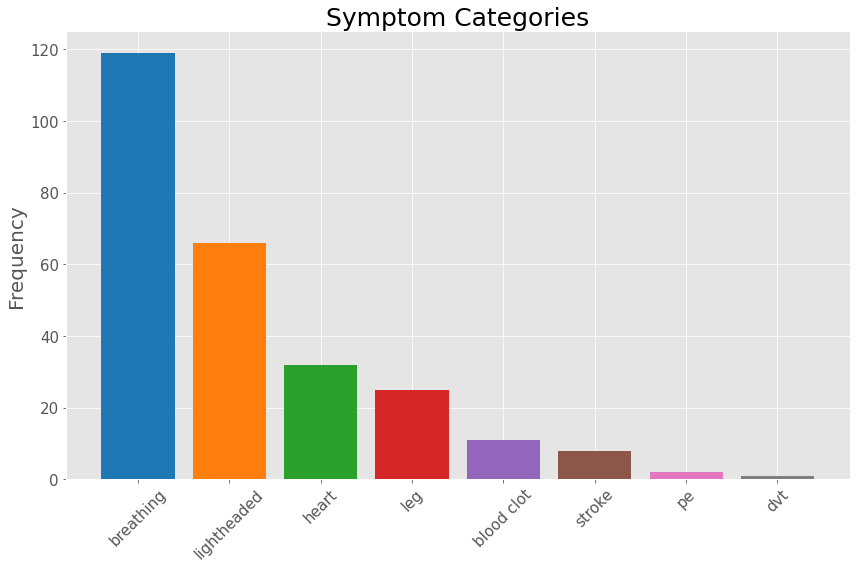

In [330]:
# plot total counts for each symptom category in final data set
# of users reporting positive diagnosis AND symptoms of interest
fig, ax = plt.subplots(figsize = (12,8))
positive_symptom_counts = positive_with_symptoms["symptom"].value_counts()
ax.bar(positive_symptom_counts.index,positive_symptom_counts.values, color = list(mcolors.TABLEAU_COLORS.values()))
ax.set_xticklabels(positive_symptom_counts.index,rotation=45, size = 15)
ax.tick_params(axis='y', labelsize = 15)
ax.set_title("Symptom Categories", size = 25)
ax.set_ylabel("Frequency", size = 20)
plt.tight_layout()
plt.show()

In [349]:
# reformat fields and calculate months after initial infection--assuming a month is ~30 days
positive_with_symptoms.rename(columns = {"time":"date_symptom","date_reported":"date_positive"}, inplace=True)
positive_with_symptoms["date_symptom"] = pd.to_datetime(positive_with_symptoms['date_symptom'])
positive_with_symptoms["months_after_infection"] = positive_with_symptoms.apply(lambda x: (x["date_symptom"] - x["date_positive"]).days/30.0, axis = 1)

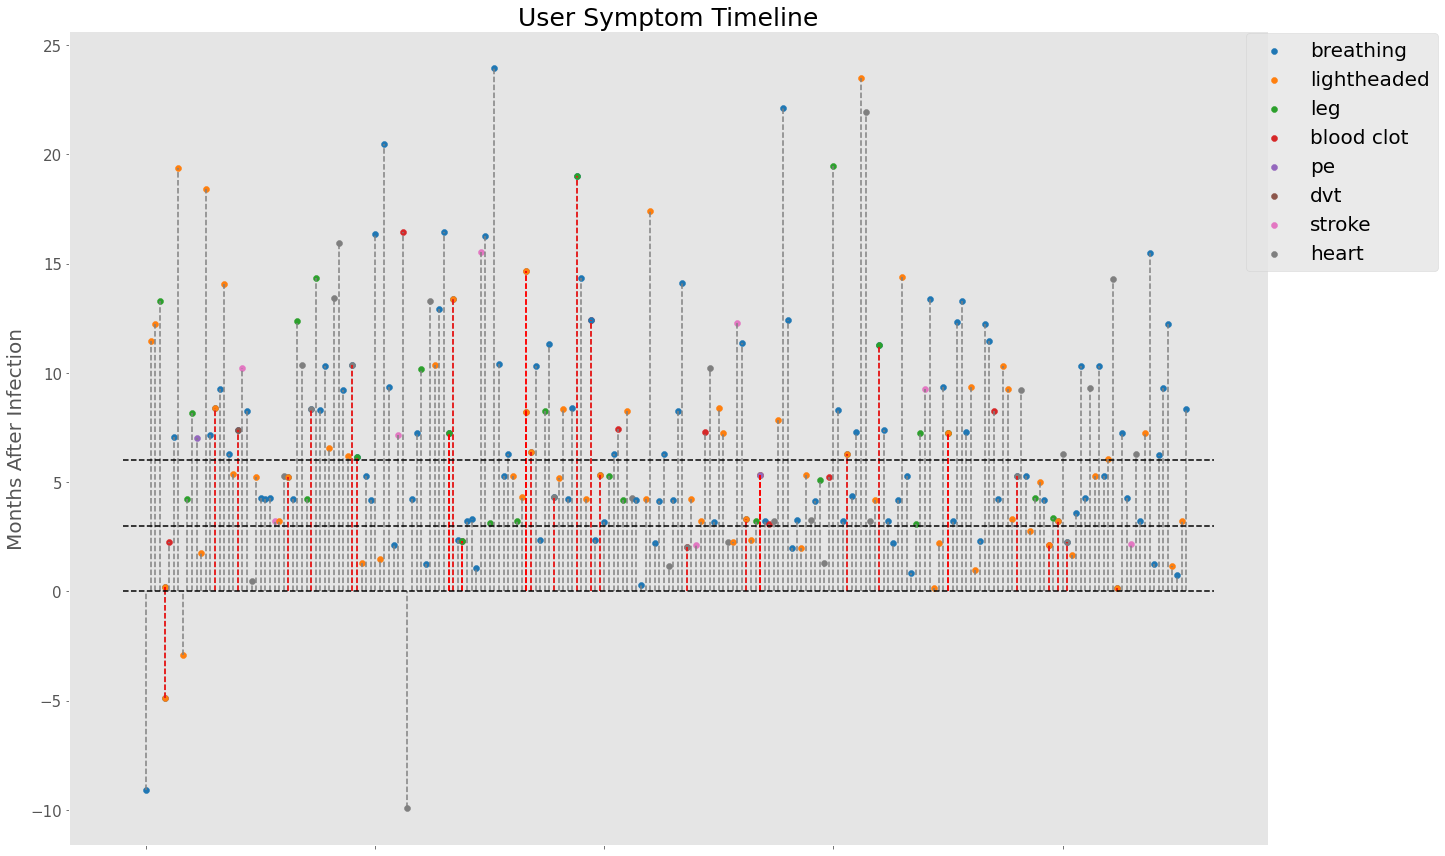

In [400]:
# create a timeline showing when users are reporting symptoms after initial infection date
color_vals = list(mcolors.TABLEAU_COLORS.values())
color_symptom_map = {symptom:color_vals[i] for i, symptom in enumerate(positive_with_symptoms["symptom"].unique())}
user_groups = positive_with_symptoms.groupby("user_id")
fig, ax = plt.subplots(figsize = (20,12))
user_count = 0
colors_done = []
for user in user_groups.groups.keys():
    symptom_count = 0
    for i, row in user_groups.get_group(user).iterrows():
        symptom_count+=1
        color = color_symptom_map[row["symptom"]]
        if color not in colors_done:
            colors_done.append(color)
            ax.scatter(y=row["months_after_infection"],x=user_count, color=color, marker="o", label=row["symptom"])
        else:
            ax.scatter(y=row["months_after_infection"],x=user_count, color=color, marker="o")
        if row["months_after_infection"] < 0:
            xmin = row["months_after_infection"]
            xmax = 0
        else:
            xmin = 0
            xmax = row["months_after_infection"]
        hlinecolor = "gray"
        if symptom_count>1:
            hlinecolor = "red"
        ax.vlines(x = user_count, ymin = xmin, ymax = xmax, color=hlinecolor, linestyle="--")
    user_count+=1
#ax.set_xticklabels(positive_symptom_counts.index,rotation=45, size = 15)
ax.tick_params(axis='y', labelsize = 15)
ax.set_ylabel("Months After Infection", size = 20)
ax.legend(bbox_to_anchor=[1.15,1.01], prop={'size':20})
ax.hlines(y = [0,3,6], xmin = -5, xmax = positive_with_symptoms.user_id.nunique()+5, linestyle="--")
ax.set_xticklabels("")
plt.grid(False)
ax.set_title("User Symptom Timeline", size = 25)
plt.tight_layout()
plt.show()

In [415]:
# print basic statistics for months after infection--grouped by symptom category
positive_with_symptoms.groupby("symptom").aggregate({"user_id":"count","months_after_infection":["mean","std","min","max"]}).reset_index()

symptom user_id months_after_infection                               
                 count                   mean       std       min        max
0   blood clot      11               6.263636  4.755358  2.033333  16.466667
1    breathing     119               6.841176  5.068521 -9.100000  23.933333
2          dvt       1               7.400000       NaN  7.400000   7.400000
3        heart      32               6.728125  5.942002 -9.933333  21.933333
4          leg      25               7.590667  4.898540  2.300000  19.466667
5  lightheaded      66               6.190404  5.221742 -4.866667  23.500000
6           pe       2               6.150000  1.202082  5.300000   7.000000
7       stroke       8               7.741667  4.976923  2.133333  15.533333